---

# Interpretable Machine Learning: Shapley Values
#### United Lunch & Learn: June 6, 2019
#### Updated: September 1, 2021

_Author: Carleton Smith_

Many of the examples and sources cited in this tutorial came from these two excellent podcast episodes by [_Linear Digressions_](http://lineardigressions.com/):

- ["Game Theory for model interpretability: Shapley Values"](http://lineardigressions.com/episodes/2018/5/6/game-theory-for-model-interpretability-shapley-values)
- ["SHAP: Shapley Values in Machine Learning"](http://lineardigressions.com/episodes/2018/5/13/shap-shapley-values-in-machine-learning)

---

<a id='top'></a>
## Tutorial Outline

- [Install Packages](#install)
- [Imports](#imports)
- [Brief Introduction](#intro)
- [Why Do We Care About Interpretable Machine Learning?](#interpret)
- [What Are Shapley Values?](#shapley-values)
- [Acquire data](#acquire)
- [Quick Preprocessing/EDA](#eda-preprocessing)
- [Preprocessing Pipeline](#pipeline)
- [Create a Model: RandomForest](#model)
- [Shapley Values in Action](#in-action)
    - [Visualize Results](#visualize)
- [Fairness and Bias](#fairness-and-bias)

---
<a id='install'></a>
## Install Packages

In [1]:
import sys
# !conda install -yc conda-forge --prefix {sys.prefix} shap

<a id='imports'></a>
---
## Import Packages

In [2]:
import os
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 12

[Back to top](#top)

<a id='intro'></a>
---
## Brief Introduction

Before demonstrating how to use Shapley Values for machine learning, let's discuss what they are in the first place. This explanation is based on these two papers:

1. [A Unified Approach to Interpreting Model Predictions](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)
2. [Consistent Individualized Feature Attribution for Tree Ensembles](https://arxiv.org/pdf/1802.03888.pdf)

#### TL;DR

Shapley Values originated in game theory and are named after famed mathematician and Nobel Prize winner, [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley). The purpose of Shapley Values from a game theory perspective is to solve the problem of assigning appropriate credit to individual players in a cooperative game. In recent years, machine learning researchers have adopted Shapley Values to assign "credit" to features for predictions produced by a complex model.


[Back to top](#top)

<a id='interpret'></a>
## Why do we care about interpretable machine learning?

There are many reasons.

- Establish trust in the model
- Better understand underlying processes
- Provide insights in how to improve the model
- Ethics and fairness

In addition to Shapley Values, several methods already exist on the market for this purpose:

- LIME
- DeepLIFT
- Layer-Wise Relevance Propagation

What sets Shapley Values apart (according to the [the first paper listed above](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)) is that Shapely values are the only one of these method that satisfy all three of the following feature importance quality requirements:

1. **Local Accuracy** - a simple model explaining a complex one around a particular point should produce the same output given the same inputs
2. **Missingness** - if a feature is missing in the input space, it should not appear in the feature attribution
3. **Consistency** - if a feature is increasing in it's contribution to the outcome, then that feature should increase in it's importance

What ends up happening with many of the other methods is that you can come up with counter-examples where you cannot acheive all 3 of these properties at the same time. Shapley Values are the only solution among these that do.

[Back to top](#top)

<a id='shapley-values'></a>
## What are Shapley Values?

### Game Theory Context Example: A Soccer Team

- 11 players make a team
- Well defined positions
- Imagine scores range 0-100
- Also imagine you have a stadium full of soccer players available

**How important are each one of the 11 players to the overall performance of the team?**

The problem is that you have 1 outcome (the score) and 11 individuals making contributions.

You start with 1 player as the whole team. This is probably not a great team, but the individual might be very good and contribute a `+10` by themself.

Then you add in another player, who is a `+9` by themself, but when you add them in, the combined score becomes `21` because of a synergistic effect.

Then you add a third player, who is a `+4`. This player alone is not great, but just happens to play well with the other two, so that player contributes a `+8` to the team score.

Then you add a fourth player (`+12`), but this player gets into fights with the first two, so only contributes a `+2` to the total score.

Then you add a fifth player. And this player is a goalie, which is a very unique position, so this becomes extremely valuable.

Now suppose we add a sixth player, who is also a goalie. Well, at this point the team already has a goalie, so it doesn't add much value to add another one, even if this player is very good. The point here is that the value a player adds to the overall outcome depends on who is already there, in addition to the order they are added.

We can go on, but you get the point. What we're doing is composing all of these coalitions of teams and measuring the change in contribution as we add in players, all while keeping track of who is already on the team and in which order they are added.

The credit attribution becomes complex and large multiplication problem, but the calculation is somewhat straightfoward:

    Add up all of the contributions created by each player over every possible coalition composition, then divide by number of scenarios you have and that's the Shapley Value for that specific player.


Check out [this link](https://clearcode.cc/blog/game-theory-attribution/) to see the math performed with a simple marketing example.

### Machine Learning Context


**Tie back to ML:**    
Swap the soccer score for a model's prediction for a particular case. And instead of creating coalitions of soccer players, we are concerned with which features play the largest role in a particular prediction. This is what Shapley Values do in a machine learning context. Let's grab some data and see it in action.

[Back to top](#top)

<a id='acquire'></a>
## Acquire Data

This is Census data from the _UCI Machine Learning Repository_: https://archive.ics.uci.edu/ml/datasets/adult

In [3]:
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                    na_values=' ?',
                    header=None)

If the above line hangs, then uncomment the line below

In [4]:
# adult = pd.read_csv('./datasets/adult.data.txt', header=None, na_values=' ?')

[Back to top](#top)

<a id='eda-preprocessing'></a>
## Quick Preprocessing/EDA

- Add column headers
- Understand dataset
    - how many rows/columns?
    - what does a row represent?
    - what is our target variable?
- Check for missing values
- Check data types
- Check for unbalanced target variable

In [5]:
adult.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Add Column Headers

**FEATURES**

1. `age`: continuous.
2. `workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
3. `fnlwgt`: continuous.
4. `education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
5. `education-num`: continuous.
6. `marital-status`: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
7. `occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
8. `race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
9. `sex`: Female, Male.
10. `capital-gain`: continuous.
11. `capital-loss`: continuousm
12. `hours-per-week`: continuous.
13. `native-country`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [6]:
features = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education_num',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
    'native_country',
    'income',
]

In [7]:
# assign column names
adult.columns = features
adult.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
# how many rows a columns?
adult.shape

(32561, 15)

In [9]:
# any missing values?
adult.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [10]:
# what are the data types?
adult.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [11]:
# what is the distribution of our target variable?
adult['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

[Back to top](#top)

<a id='pipeline'></a>
## Preprocessing

In the interest of time, I packaged these preprocessing steps into `Pipelines`.

**PREPROCESSING STEPS**
1. Separate target variable from features - sklearn requires this.
2. Peform a train-test split - Always do this before manipulating dataset
3. With training data:
    - **SEPARATE** numeric columns from categorical ones
    - **NUMERIC DF** preprocessing:
        - Replace nan values
        - Standardize features
   
    - **CATEGORICAL DF** preprocessing:
        - Replace nan values
        - Create dummy variables
    - **CONCATENATE** numeric and categorical DF
    - **ENCODE** target variable
<br>
<br>
4. Package these steps into a `Pipeline`

In [12]:
# make a list of numeric and categorical column names
num_cols = [col for col in adult.columns if adult[col].dtype != 'object']
cat_cols = [col for col in adult.columns if col not in num_cols + ['income']]

# separate features from target variable
X = adult.drop('income', axis=1)
y = adult['income']

# perform a train-test split.... why? stratify on y?
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=24
)

def feature_extractor(df):
    return df.drop('income', axis=1)


def categorical_extractor(df):
    return df.select_dtypes(include=['object'])


def numeric_extractor(df):
    return df.select_dtypes(exclude=['object'])

# create custom transformers
cat_transformer = FunctionTransformer(categorical_extractor, validate=False)
num_transformer = FunctionTransformer(numeric_extractor, validate=False)

# make numeric pipe
num_pipe = Pipeline([
    ('numeric_transformer', num_transformer),
    ('num_im', SimpleImputer(strategy='median')),
    ('StandardScaler', StandardScaler())
])

# make categorical pipe
cat_pipe = Pipeline([
    ('cat_transformer', cat_transformer),
    ('cat_im', SimpleImputer(strategy='most_frequent')),
    ('OrdinalEncoder', OrdinalEncoder())
])


# make FeatureUnion
feat_union = FeatureUnion([
    ('num_pipe', num_pipe),
    ('cat_pipe', cat_pipe)
])

# make final feature pipe
feature_pipe = Pipeline([
    ('feat_union', feat_union)
])

#### Use this pipeline to _fit_ and _transform_ `X_train`

In [13]:
# fit and transform training data
X_train_prepared = pd.DataFrame(
    feature_pipe.fit(X_train).transform(X_train),
    index=X_train.index,
    columns=X_train.columns)
X_train_prepared.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
10348,-0.924812,0.012344,1.133671,-0.146749,-0.214716,-0.843279,3.0,9.0,4.0,7.0,1.0,4.0,1.0,38.0
11062,1.712486,2.162427,-1.198581,-0.146749,-0.214716,-1.572986,3.0,1.0,5.0,7.0,1.0,2.0,0.0,38.0
25734,-1.144586,2.329859,-0.421164,-0.146749,-0.214716,0.616136,3.0,11.0,4.0,11.0,1.0,4.0,1.0,38.0
401,-0.778295,-0.763740,-0.032455,-0.146749,-0.214716,-0.032493,3.0,15.0,4.0,7.0,1.0,4.0,0.0,38.0
28063,1.126420,1.600147,1.133671,0.844477,-0.214716,1.183686,4.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0


In [14]:
# transform testing data
X_test_prepared = pd.DataFrame(
    feature_pipe.transform(X_test),
    index=X_test.index,
    columns=X_test.columns)
X_test_prepared.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
2093,0.906645,-0.129961,1.133671,-0.146749,-0.214716,0.535058,3.0,9.0,2.0,11.0,0.0,4.0,1.0,38.0
29473,-1.437619,1.329928,-1.198581,-0.146749,-0.214716,-0.032493,3.0,1.0,5.0,7.0,3.0,4.0,0.0,38.0
14123,0.174062,1.430095,-2.753415,-0.146749,-0.214716,-0.032493,3.0,4.0,2.0,9.0,0.0,4.0,1.0,25.0
10193,0.906645,-1.536521,-0.421164,-0.146749,-0.214716,-0.032493,0.0,11.0,2.0,12.0,0.0,4.0,1.0,38.0
18789,0.320579,1.045784,-0.032455,-0.146749,-0.214716,-0.032493,3.0,15.0,2.0,0.0,0.0,4.0,1.0,38.0


#### Use `LabelEncoder` to transform the `income` to be numeric

In [15]:
y_train[:5]

10348     <=50K
11062     <=50K
25734     <=50K
401       <=50K
28063      >50K
Name: income, dtype: object

In [16]:
# fit and transform y_train
le = LabelEncoder()
y_train_encoded = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_train_encoded[:5]

10348    0
11062    0
25734    0
401      0
28063    1
dtype: int64

In [17]:
# transform y_test
y_test_encoded = pd.Series(le.transform(y_test), index=y_test.index)
y_test_encoded[:5]

2093     1
29473    0
14123    0
10193    0
18789    0
dtype: int64

#### Calculate Baseline

In [18]:
y_test_encoded.value_counts()[0] / y_test_encoded.value_counts().sum()

0.7592384072064694

[Back to top](#top)

<a id='model'></a>
## Create a Model: `RandomForest`

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
rf = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced'
)
rf.fit(X_train_prepared, y_train_encoded)

In [ ]:
# make predictions for training and test:
y_pred_train = rf.predict(X_train_prepared)
y_pred_test = rf.predict(X_test_prepared)

In [ ]:
print('CLASSIFICATION METRICS FOR TRAINING: \n')
print(classification_report(y_train_encoded, y_pred_train))
print('#########################################################\n')

print('CLASSIFICATION METRICS FOR TESTING: \n')
print(classification_report(y_test_encoded, y_pred_test))

In [ ]:
accuracy_score(y_test_encoded, y_pred_test)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(rf, X_train_prepared, y_train_encoded, scoring='recall', cv=5)

#### Print Top 10 Features

In [ ]:
feat_imp_lst = list(zip(X_train_prepared.columns, rf.feature_importances_))
feat_lst = sorted(feat_imp_lst, key=lambda x: x[1], reverse=True)
for tup in feat_lst[:10]:
    print(tup)

[Back to top](#top)

<a id='in-action'></a>
## Shapley Values in Action

The `shap` package includes a C++ optimized implementation for several popular Python tree models.

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_prepared)

In [ ]:
import pickle

In [ ]:
# with open('rf-explainer.pickle', 'wb') as f:
#     pickle.dump(explainer, f, pickle.HIGHEST_PROTOCOL)
# with open('rf-shap-values.pickle', 'wb') as s:
#     pickle.dump(shap_values, s, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('rf-explainer.pickle', 'rb') as f:
    explainer2 = pickle.load(f)
with open('rf-shap-values.pickle', 'rb') as s:
    shap_values2 = pickle.load(s)

[Back to top](#top)

<a id='visualize'></a>
### Plot the Shapley Values for the first observation in `X_train_prepared`

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# show 
display(X_train_prepared.iloc[0])
print()
print("Actual Label:\t\t{}".format(y_train_encoded[0]))
print("Predicted Label:\t{}".format(y_pred_train[0]))

# plot the explanation of each feature for the first prediction
shap.force_plot(explainer2.expected_value[0], shap_values[1][0, :], X_train_prepared.iloc[0, :])

This is great, but we have 32,561 observations. We can visualize the entire data set as a distribution:

#### Look at explanations for 100 Class 0 Predictions

In [ ]:
# make constants for which class is of interest
EXP_VALUE = 0
PRED_CLASS = 0
NUM_OBS = 100

# grab first 100 observations predicted class 1
data_to_plot = X_train_prepared.reset_index(drop=True)[y_pred_train == PRED_CLASS].iloc[:NUM_OBS, :]

# grab row indexes for these instances
row_idx = data_to_plot.index

# create the plot
shap.force_plot(
    explainer2.expected_value[EXP_VALUE],
    shap_values[PRED_CLASS][row_idx],
    data_to_plot
)

#### Look at explanations for Class 1 Predictions

In [ ]:
# make constants for which class is of interest
EXP_VALUE = 1
PRED_CLASS = 1
NUM_OBS = 100

# grab first 100 observations predicted class 1
data_to_plot = X_train_prepared.reset_index(drop=True)[y_pred_train == PRED_CLASS].iloc[:NUM_OBS, :]

# grab row indexes for these instances
row_idx = data_to_plot.index

# create the plot
shap.force_plot(
    explainer2.expected_value[EXP_VALUE],
    shap_values[PRED_CLASS][row_idx],
    data_to_plot
)

[Back to top](#top)

<a id='future-work'></a>
## NEW!

Fairness and Bias Auditing with [Aequitas](https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb).

In [ ]:
# !pip install -yc --prefix {sys.prefix} git+https://github.com/dssg/aequitas.git

<a id='fairness-and-bias'></a>
## Fairness and Bias
1. [Visit the Aequitas project website](http://www.datasciencepublicpolicy.org/projects/aequitas/)
2. [Aequitas Fairness GitHub](https://github.com/dssg/aequitas)
3. [Aequitas API Docs](https://dssg.github.io/aequitas/api/aequitas.html)
4. [Aequitas Example](https://dssg.github.io/aequitas/examples/compas_demo.html)

In [ ]:
# !pip install aequitas

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings; warnings.simplefilter('ignore')

In [21]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
pd.set_option("display.max_columns", 99)

### Load sample data

In [22]:
RAW_DATA = 'https://raw.githubusercontent.com/dssg/aequitas/master/examples/data/compas_for_aequitas.csv'
df = pd.read_csv(RAW_DATA)

In [23]:
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


### About the data
Risk assessment by race

COMPAS produces a risk score that predicts a person’s likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of “low” risk according to COMPAS, while a 1 indicates “high” or “medium” risk.

In [24]:
aq_palette = sns.diverging_palette(225, 35, n=2)

Race by label

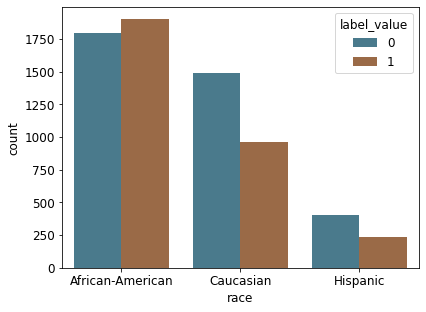

In [25]:
label_by_race = sns.countplot(
    x="race", hue="label_value", 
    data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], 
    palette=aq_palette
)

Look at the prediction distributons along the race, sex, and age attributes.

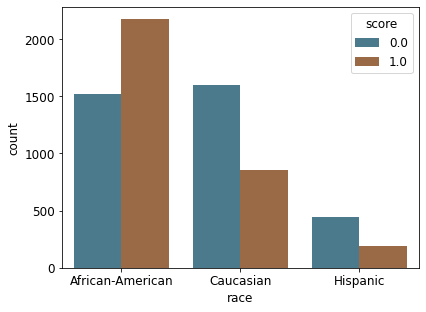

In [26]:
by_race = sns.countplot(
            x="race", hue="score", 
            data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])],
            palette=aq_palette
)

Labels by Sex

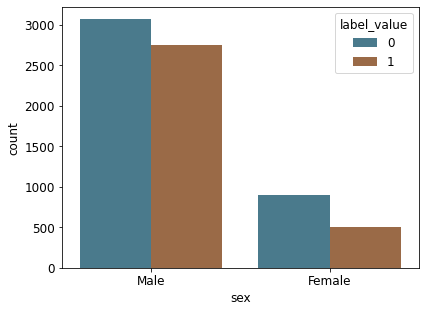

In [27]:
label_by_sex = sns.countplot(
    x="sex", hue="label_value", 
    data=df, palette=aq_palette
)

Predictions by Sex

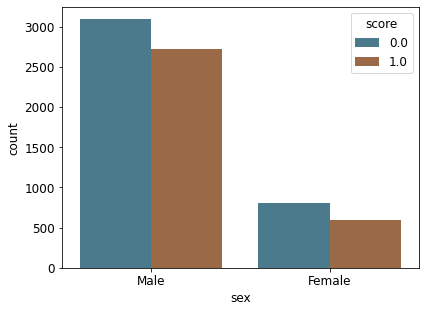

In [28]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

Labels by Age

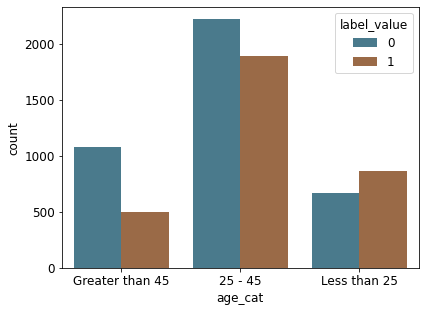

In [29]:
label_by_age = sns.countplot(
    x="age_cat", hue="label_value", 
    data=df, palette=aq_palette
)

Predictions by Age

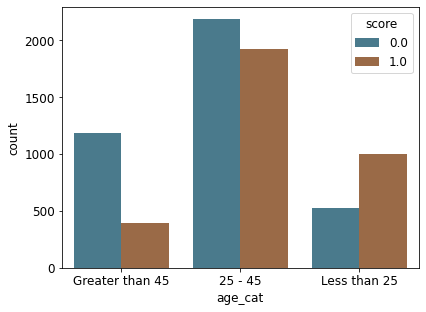

In [30]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

The graphs above show the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39), though the predictions do not match the base rates.

#### Initialize a `Group()` instance to see metrics in cross tabulations

In [31]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 0 {'rank_abs': [3317]}


In [32]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,0.333333,0.875000,0.750000,8,24,0.002412,0.250000,2,3,21,6,9,23,32,7214,0.281250
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057281,0.298273,87,129,318,103,232,405,637,7214,0.364207
4,0,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,0.100000,0.833333,0.750000,12,6,0.003618,0.666667,3,1,5,9,10,8,18,7214,0.555556
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023817,0.209549,36,90,208,43,133,244,377,7214,0.352785
6,0,binary 0/1,3317,sex,Female,0.608434,0.678930,0.242537,0.487310,0.321070,0.391566,0.757463,0.512690,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989
7,0,binary 0/1,3317,sex,Male,0.629132,0.675799,0.330100,0.364637,0.324201,0.370868,0.669900,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105
8,0,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.468240,741,706,1479,1183,1889,2220,4109,7214,0.459723
9,0,binary 0/1,3317,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.250000,181,285,897,213,498,1078,1576,7214,0.315990


#### Plot the false negative rates

These show how often the model misses someone that does commit another crime within that group.

In [33]:
aqp = Plot()

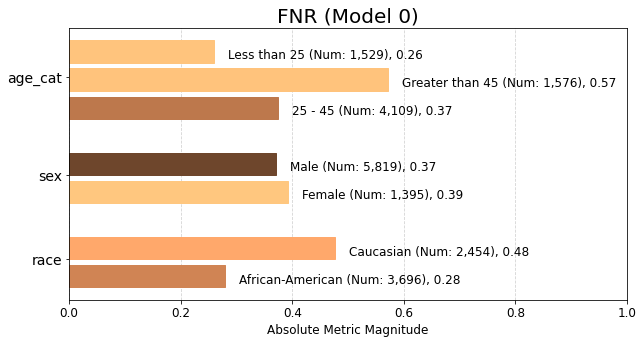

In [34]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

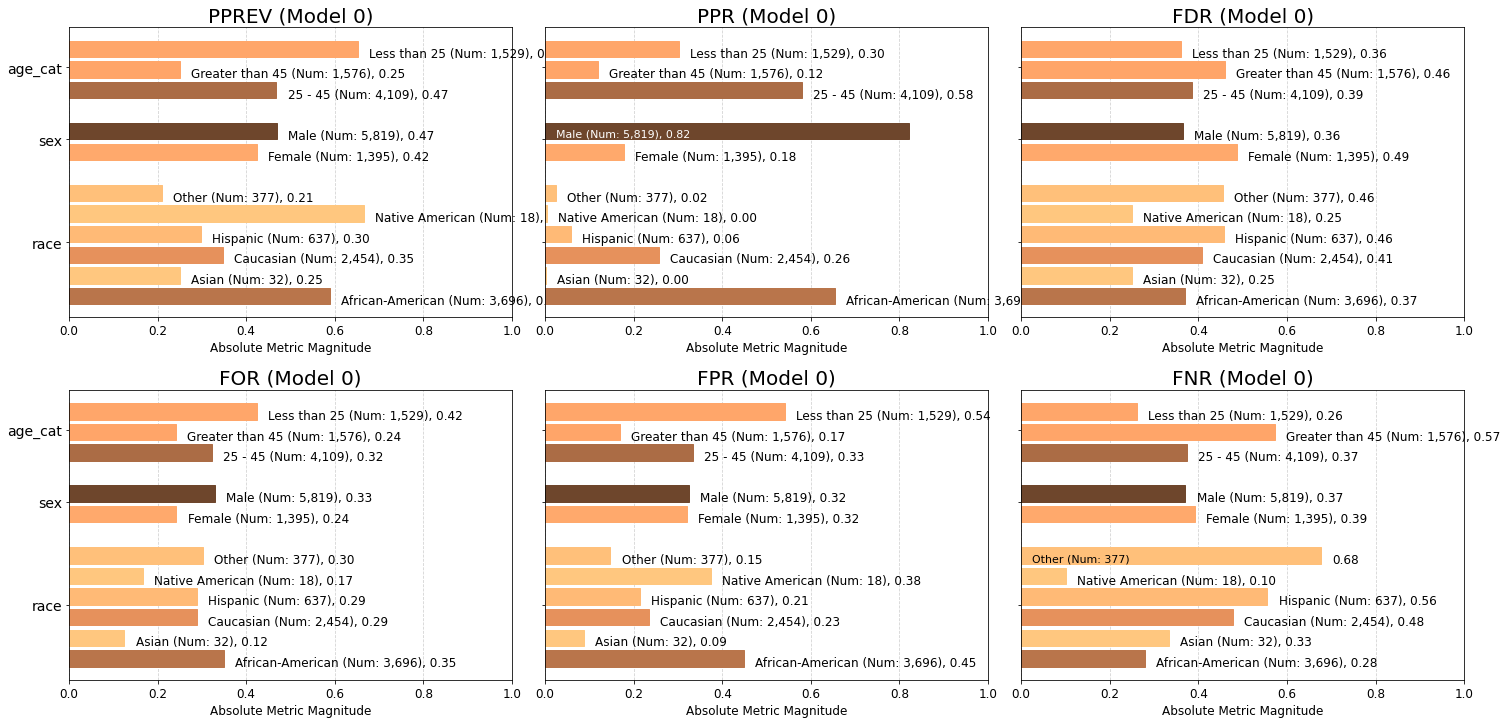

<Figure size 460.8x345.6 with 0 Axes>

In [35]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

[Back to top](#top)

## Scratch work

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_lst = {
    "n_estimators": np.arange(10, 105, 10),
    "max_depth": [None, 30, 10, 5],
    "class_weight": ['balanced'],
    "oob_score": [True],
}

In [ ]:
rs = RandomizedSearchCV(rf, param_distributions=param_lst, verbose=2)

In [ ]:
rs.fit(X_train_prepared, y_train_encoded)

In [ ]:
rs.best_estimator_